In [2454]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast

In [2455]:
sns.set(rc={'figure.figsize':(15,8)})

In [2456]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('result_std1.csv')
df['date'] = pd.to_datetime(df.date)

df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [2457]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')
df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [2458]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [2459]:
df.loc[(df.duplicated(subset=['date', 'sorted_pair'], keep='first'))].sort_values(by=['date', 'sorted_pair'])

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,open_price_scnd_stock,open_date,close_limit,stop_limit,halflife,days_open,data_ini,data_fin,setor,sorted_pair


In [2460]:
def result_calculator(row):
    
    
    long_result = row['price_fst_stock'] - row['open_price_first_stock']
    short_result = row['open_price_scnd_stock'] - row['price_scnd_stock']
    
#     long_result = row['open_price_first_stock'] - row['price_fst_stock']
#     short_result = row['price_scnd_stock'] - row['open_price_scnd_stock']

    result = long_result + short_result
    
    if row['residual_open'] > row['std_open_residual']:
        result = - result

    return result 

In [2726]:
def result_calculator(row, kind='CN'):
    
    if kind=='CN':
        multiplier = 1
    if kind == 'BN':
        multiplier = row.beta_open
    
    
    if row['residual_open'] < row['std_open_residual']:
        long_result = np.log(row['price_fst_stock'] / row['open_price_first_stock'])
        short_result = np.log(row['open_price_scnd_stock'] / row['price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = long_result + short_result
    
    elif row['residual_open'] > row['std_open_residual']:
        long_result = np.log(row['open_price_first_stock'] / row['price_fst_stock'])
        short_result = np.log(row['price_scnd_stock'] / row['open_price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = long_result + short_result

    return result 

In [2727]:
cond = (df.status.isin(['True', 'close']))

In [2729]:
df.loc[cond, 'result'] = df.loc[cond].apply(lambda row: result_calculator(row), axis=1)
df.loc[cond, 'result_beta_neutral'] = df.loc[cond].apply(lambda row: result_calculator(row, kind='BN'), axis=1)


In [2532]:
# Cash Neutral

quant2 = df.loc[cond].open_price_first_stock / df.loc[cond].open_price_scnd_stock
quant1 = 1

long_result = df.loc[cond,'price_fst_stock'] - df.loc[cond,'open_price_first_stock']
short_result = df.loc[cond,'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']

result = (quant1 * long_result) + (short_result * quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_cash_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_cash_neutral'] = - result


In [2533]:
# Beta Neutral

quant2 = df.loc[cond].beta_open
quant1 = 1

result = (quant1) * (df.loc[cond, 'price_fst_stock'] - df.loc[cond, 'open_price_first_stock']) + (df.loc[cond, 'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']) * (quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_beta_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_beta_neutral'] = - result

In [2730]:
closed = df.loc[df.status=='close'].copy()

closed['is_profit'] = closed['result'] > 0
# closed['is_profit_CN'] = closed['result_cash_neutral'] > 0
closed['is_profit_BN'] = closed['result_beta_neutral'] > 0


In [2736]:
result = closed[['result', 'result_beta_neutral']].sum()
accuracy = closed[['is_profit','is_profit_BN']].mean()

In [2737]:
result_table = {'result': result.values,
                'accuracy': accuracy.values,                
               }
pd.DataFrame(result_table, index=['normal', 'beta_neutral'])

,result,accuracy
normal,4.109702,0.511137
beta_neutral,8.356766,0.507620


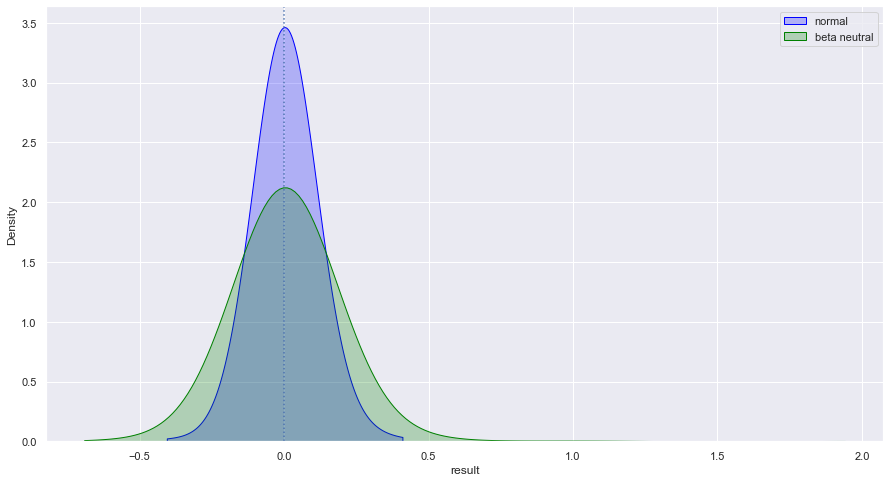

In [2738]:
sns.kdeplot(x=closed.result, color='blue', label='normal', bw_adjust=5, cut=0, fill=True)
# sns.kdeplot(x=closed.result_cash_neutral, color='red', label='cash neutral', bw_adjust=5, cut=0, fill=True)
sns.kdeplot(x=closed.result_beta_neutral, color='green', label='beta neutral', bw_adjust=5, cut=0, fill=True)

plt.axvline(x=0, linestyle='dotted')
plt.legend()
plt.show()

In [2538]:
# Close by residual
closed_by_residual = closed.loc[abs(df.last_residual) < df.close_limit,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T
closed_by_residual

,sum,count
result,1.854394,27.0
result_cash_neutral,59.558230,27.0
result_beta_neutral,80.075961,27.0


In [2539]:
# stop by stop
closed_by_stop = closed.loc[abs(df.last_residual) > df.stop_limit,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T
closed_by_stop

,sum,count
result,-8.848446,322.0
result_cash_neutral,-210.390263,322.0
result_beta_neutral,-305.667564,322.0


In [2740]:
# stop by halflife
closed_by_halflife = closed.loc[closed.days_open > closed.halflife,['result', 'result_beta_neutral']].agg([sum, 'count']).T
closed_by_halflife

,sum,count
result,10.894514,521.0
result_beta_neutral,19.022849,521.0


In [2741]:
# closed = closed.loc[closed.halflife.between(0,21)]

In [2744]:
halfyear_accuracy

,date,variable,accuracy
0,2019-07-31,normal,0.625000
1,2020-01-31,normal,0.511111
2,2020-07-31,normal,0.521053
3,2021-01-31,normal,0.532110
4,2021-07-31,normal,0.436090
5,2022-01-31,normal,0.559633
6,2022-07-31,normal,0.503106
7,2019-07-31,beta neutral,0.625000
8,2020-01-31,beta neutral,0.570370
9,2020-07-31,beta neutral,0.468421


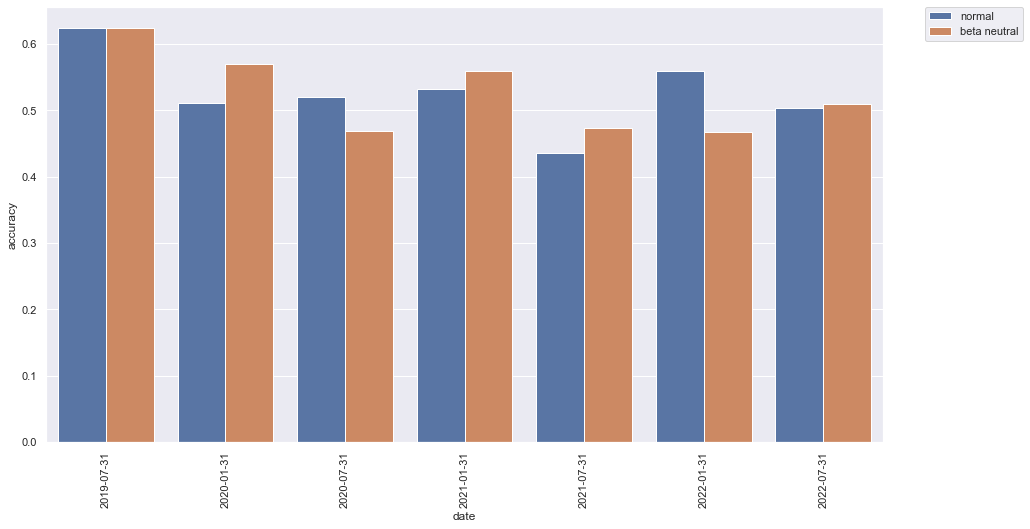

In [2743]:
# Halfyear accuracy
halfyear_accuracy = closed.set_index('date').resample('6M')[['is_profit', 'is_profit_BN']].mean().reset_index()
halfyear_accuracy.columns = ['date', 'normal', 'beta neutral']
halfyear_accuracy['date'] = halfyear_accuracy['date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='date', value_name='accuracy')

sns.barplot(x='date', y='accuracy', hue='variable', data=halfyear_accuracy)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

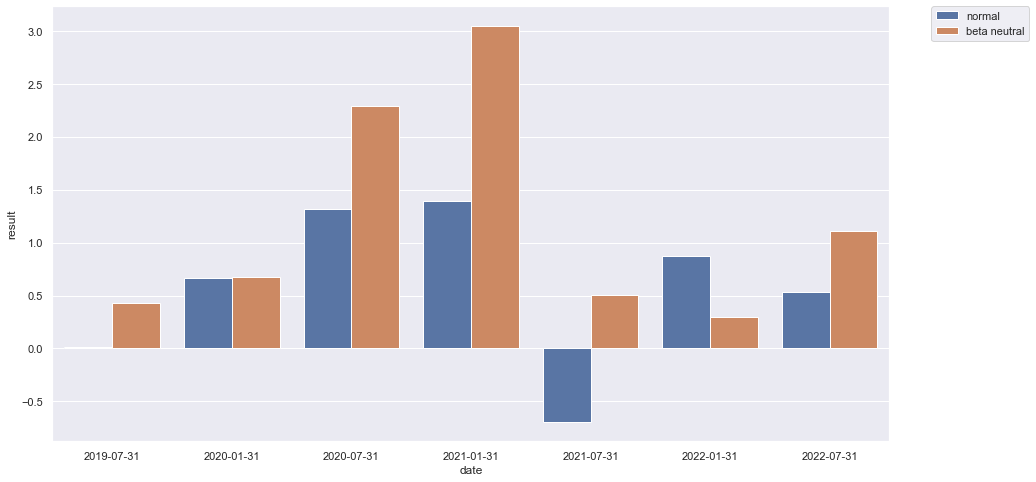

In [2762]:
# Halfyear results
halfyear_results = closed.set_index('date').resample('6M')[['result', 'result_beta_neutral']].sum().reset_index()
halfyear_results.columns = ['date', 'normal', 'beta neutral']
halfyear_results['date'] = halfyear_results.date.dt.date
halfyear_results = halfyear_results.melt(id_vars='date', value_name='result')

sns.barplot(x='date', y='result', hue='variable', data=halfyear_results)
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [2746]:
closed_daily = closed.groupby('date').agg({'result':'mean', 'result_beta_neutral':'mean'})

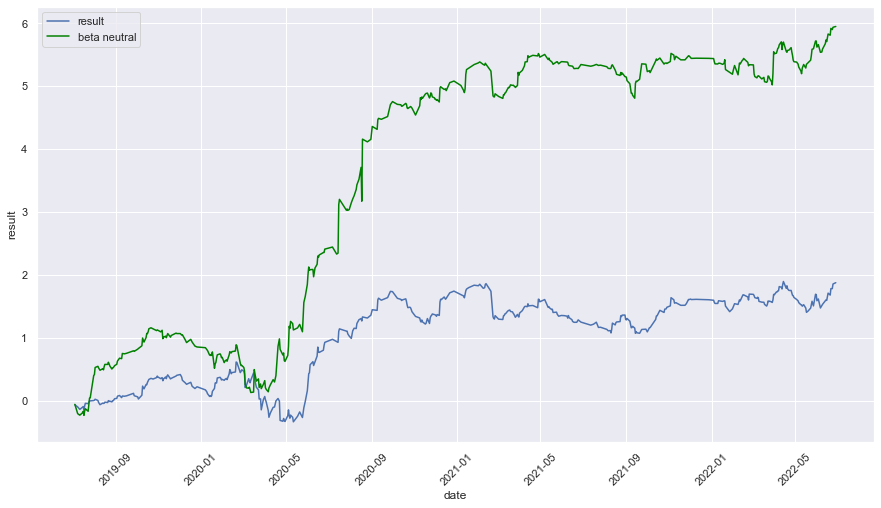

In [2747]:
sns.lineplot(x=closed_daily.index, y=closed_daily.result.cumsum(), label='result')
# sns.lineplot(x=closed_daily.index, y=closed_daily.result_cash_neutral.cumsum(),color='red', label='cash neutral')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_beta_neutral.cumsum(),color='green', label='beta neutral')


plt.xticks(rotation=45)
plt.show()

[]

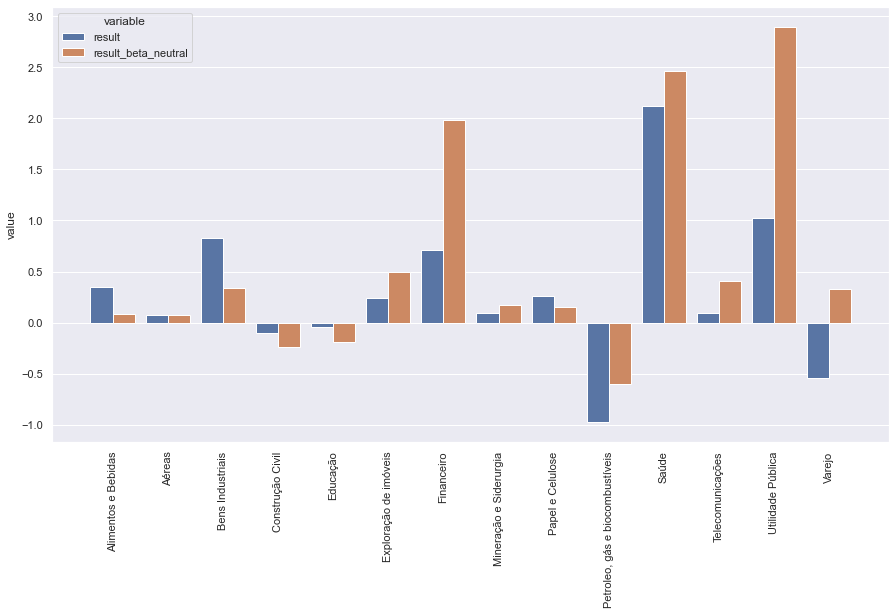

In [2750]:
closed_setor = closed[['setor', 'result', 'result_beta_neutral']].melt(id_vars='setor')
closed_setor = closed_setor.groupby(['setor', 'variable'], as_index=False).sum()

plt.figure(figsize=(15,8))

sns.barplot(x='setor', y='value', hue='variable', data=closed_setor, orient='v')
# plt.grid(axis='x')
plt.xticks(rotation=90)
plt.xlabel(None)
plt.plot()

In [2751]:
closed_setor.pivot(index='setor', columns='variable', values='value')

variable,result,result_beta_neutral
setor,,
Alimentos e Bebidas,0.347434,0.080648
Aéreas,0.072371,0.071178
Bens Industriais,0.824567,0.340602
Construção Civil,-0.104085,-0.239988
Educação,-0.047222,-0.186650
Exploração de imóveis,0.236697,0.493060
Financeiro,0.706203,1.986108
Mineração e Siderurgia,0.093632,0.169157
Papel e Celulose,0.260459,0.151085


[]

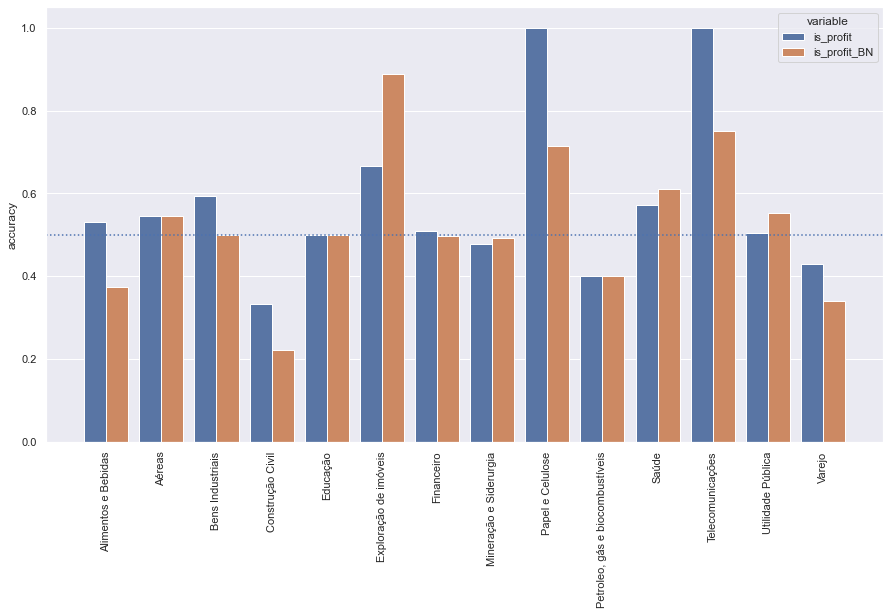

In [2753]:
closed_setor_accuracy = closed[['setor', 'is_profit', 'is_profit_BN']].melt(id_vars='setor', value_name='accuracy')
closed_setor_accuracy = closed_setor_accuracy.groupby(['setor', 'variable'], as_index=False).mean()
sns.barplot(x='setor', y='accuracy', hue='variable', data=closed_setor_accuracy, orient='v', )
plt.axhline(y=0.5, linestyle='dotted')
plt.xlabel(None)
plt.xticks(rotation=90)
# plt.grid(axis='x')
plt.plot()

In [2754]:
closed_setor_accuracy.pivot(index='setor', columns='variable', values='accuracy')

variable,is_profit,is_profit_BN
setor,,
Alimentos e Bebidas,0.531250,0.375000
Aéreas,0.545455,0.545455
Bens Industriais,0.593750,0.500000
Construção Civil,0.333333,0.222222
Educação,0.500000,0.500000
Exploração de imóveis,0.666667,0.888889
Financeiro,0.509434,0.498113
Mineração e Siderurgia,0.477612,0.492537
Papel e Celulose,1.000000,0.714286


In [2756]:
pair_closed = closed.groupby('sorted_pair').agg(
    result_sum=('result', 'mean'),
    result_mean=('result', 'mean'),
    count=('result', 'count'),
    accuracy=('is_profit', 'mean'),
    sector=('setor', 'last')
    )

pair_closed.loc[pair_closed['count']>3].sort_values(by=['accuracy', 'count'], ascending=False).head(25)

,result_sum,result_mean,count,accuracy,sector
sorted_pair,,,,,
"(KLBN11, SUZB3)",0.037208,0.037208,7,1.000000,Papel e Celulose
"(TIMS3, VIVT3)",0.022358,0.022358,4,1.000000,Telecomunicações
"(BBDC3, BBDC4)",0.007150,0.007150,9,0.888889,Financeiro
"(BBAS3, ITSA4)",0.021131,0.021131,6,0.833333,Financeiro
"(ELET6, EQTL3)",0.027408,0.027408,10,0.800000,Utilidade Pública
"(ITSA4, ITUB4)",0.010456,0.010456,5,0.800000,Financeiro
"(BRAP4, GGBR4)",0.068471,0.068471,9,0.777778,Mineração e Siderurgia
"(CCRO3, RAIL3)",0.053841,0.053841,12,0.750000,Bens Industriais
"(ABEV3, BRFS3)",0.075996,0.075996,8,0.750000,Alimentos e Bebidas


In [55]:
# pair_closed.to_excel('pares_parcial.xlsx')

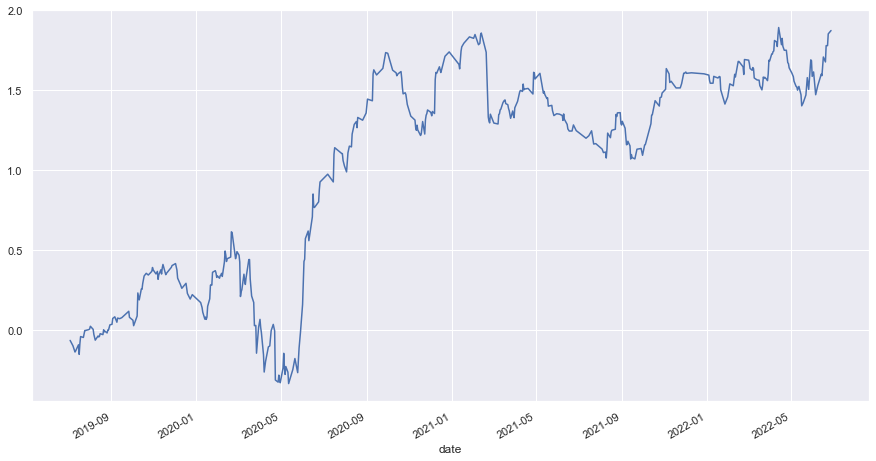

In [2757]:
closed_daily.result.cumsum().plot()

In [2446]:
closed.columns

Index(['date', 'pair', 'status', 'price_fst_stock', 'price_scnd_stock',
       'beta_open', 'beta_close', 'last_residual', 'std_residual',
       'std_open_residual', 'residual_open', 'open_price_first_stock',
       'open_price_scnd_stock', 'open_date', 'close_limit', 'stop_limit',
       'halflife', 'days_open', 'data_ini', 'data_fin', 'setor', 'sorted_pair',
       'result', 'cash', 'result_cash_neutral', 'result_beta_neutral',
       'is_profit', 'is_profit_CN', 'is_profit_BN'],
      dtype='object')

In [2556]:
closed[['price_fst_stock','price_scnd_stock', 'open_price_first_stock', 'open_price_scnd_stock','result']]

,price_fst_stock,price_scnd_stock,open_price_first_stock,open_price_scnd_stock,result
6,49.09,39.25,44.16,35.57,0.007387
9,55.47,40.71,53.12,39.64,-0.016654
11,53.55,38.24,54.30,37.78,0.026011
17,50.85,35.31,50.97,36.53,-0.031611
24,47.10,33.32,48.94,33.52,0.032338
...,...,...,...,...,...
8856,12.29,20.76,11.79,20.94,0.050167
8869,13.28,27.09,14.39,29.08,0.009388
8884,3.04,13.10,4.26,17.05,-0.073874
8893,3.13,11.43,3.03,11.10,-0.003174


In [2758]:
closed.groupby('sorted_pair').result.agg(['sum', 'count']).sort_values(by='sum', ascending=False).sum()

sum        4.109702
count    853.000000
dtype: float64

In [2719]:
cumsum_result.iloc[-1]

1.873770875739889

In [2759]:
cumsum_ibov = np.cumsum(np.log(ibov/ibov.shift()))
cumsum_result = np.cumsum(closed.groupby('date').result.mean())
cumsum_result_BN = np.cumsum(closed.groupby('date').result_beta_neutral.mean())

In [2725]:
(cumsum_result.iloc[-1]*100 )/ (closed.groupby('date').result.mean().std()* math.sqrt(252) * 100)

1.9763646857691681

In [2760]:
(cumsum_result_BN.iloc[-1]*100 )/ (closed.groupby('date').result_beta_neutral.mean().std()* math.sqrt(252) * 100)

3.618321998410413

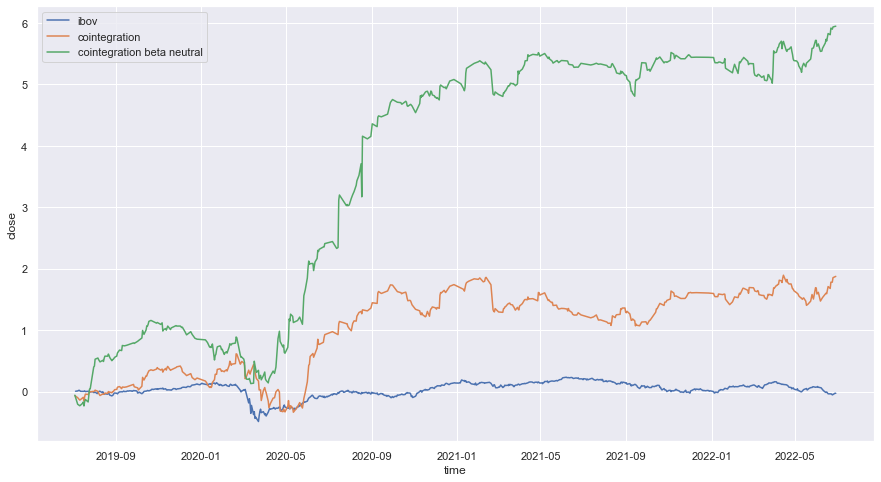

In [2761]:
sns.lineplot(x=cumsum_ibov.index, y=cumsum_ibov.close, label='ibov')
sns.lineplot(x=cumsum_result.index, y=cumsum_result, label='cointegration')
sns.lineplot(x=cumsum_result_BN.index, y=cumsum_result_BN, label='cointegration beta neutral')


In [2644]:
ibov.loc['2020'].pct_change().std()[0]* math.sqrt(252) * 100

44.60894729318973